# ***Animal Identification using Convolutional Neural Networks***

Arya Subramanyam



## **Install Deep Lake**

In [ ]:
from IPython.display import clear_output
!pip3 install deeplake
!pip install torchnet
clear_output()

SyntaxError: ignored

## **Data Preprocessing**

Reference = https://docs.activeloop.ai/tutorials

In [ ]:
import deeplake
from PIL import Image
import numpy as np
import os, time
import torch
from torchvision import transforms, models

# Connect to the training and testing datasets
ds_train = deeplake.load('hub://activeloop/animal10n-train')
ds_test = deeplake.load('hub://activeloop/animal10n-test')

|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/animal10n-train



-

hub://activeloop/animal10n-train loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/animal10n-test



-

hub://activeloop/animal10n-test loaded successfully.



Transform the images

In [ ]:
tform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # using ImageNet mean and std
])

Load the dataset

In [ ]:
batch_size = 32

# Since torchvision transforms expect PIL images, we use the 'pil' decode_method for the 'images' tensor. This is much faster than running ToPILImage inside the transform
train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, transform = {'images': tform, 'labels': None}, batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, batch_size = batch_size, decode_method = {'images': 'pil'})

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## **Choose which model to train**

Uncomment the code of the model you wish to use

### Baseline CNN

In [ ]:
# import torch
# import torch.nn as nn

# class BaselineCNN(nn.Module):
    
#     def __init__(self):
#         super(BaselineCNN, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.relu1 = nn.ReLU()
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.relu2 = nn.ReLU()
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.fc1 = nn.Linear(in_features=32 * 14 * 14, out_features=228)
#         self.fc2 = nn.Linear(in_features=228, out_features=10)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
#         x = self.maxpool1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
#         x = self.maxpool2(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x


# model = BaselineCNN()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)


### ResNet from Scratch

In [ ]:
# model = models.resnet18(pretrained=False)
# model.fc = torch.nn.Linear(model.fc.in_features, len(ds_train.labels.info.class_names))
# model.to(device)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

### ResNet Pre-trained

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(ds_train.labels.info.class_names))
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 28.2MB/s]


## **Training the Model**

Reference = https://docs.activeloop.ai/tutorials

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):

    model.train()

    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    
    for i, data in enumerate(data_loader):
        inputs = data['images']
        labels = torch.squeeze(data['labels'])

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        running_loss += loss.item()
        if i % 100 == 0:    # print every 100 batches
            batch_time = time.time()
            speed = (i+1)/(batch_time-start_time)
            print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                  (i, running_loss, speed, accuracy))

            running_loss = 0.0
            total = 0
            correct = 0

In [ ]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def test_model(model, data_loader, device, epoch):
    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs = data['images']
            labels = torch.squeeze(data['labels'])

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_positives += ((predicted == labels) & (labels == 1)).sum().item()
            false_positives += ((predicted != labels) & (labels == 0)).sum().item()
            false_negatives += ((predicted != labels) & (labels == 1)).sum().item()


        accuracy = 100 * correct / total
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_score = 2 * precision * recall / (precision + recall + 1e-7)

        print('Finished Testing')
        print('Epoch: %d' % (epoch))
        print('Testing accuracy: %.1f %%' % (accuracy))
        print('Precision: %.4f' % (precision))
        print('Recall: %.4f' % (recall))
        print('F1 Score: %.4f' % (f1_score))

        class_names = ds_test.labels.info.class_names


**Train and test for 20 epochs!**

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, optimizer, train_loader, device)

    test_model(model, test_loader, device, epoch)
  
print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 2.417, speed: 0.12, accuracy: 12.50 %
[  100] loss: 220.406, speed: 4.06, accuracy: 20.50 %
[  200] loss: 188.547, speed: 5.02, accuracy: 38.66 %
[  300] loss: 165.259, speed: 5.14, accuracy: 47.47 %
[  400] loss: 146.065, speed: 5.43, accuracy: 53.31 %
[  500] loss: 133.953, speed: 5.57, accuracy: 55.69 %
[  600] loss: 122.657, speed: 5.51, accuracy: 59.75 %
[  700] loss: 115.708, speed: 5.64, accuracy: 62.44 %
[  800] loss: 111.285, speed: 5.74, accuracy: 62.44 %
[  900] loss: 105.386, speed: 5.69, accuracy: 65.03 %
[ 1000] loss: 100.846, speed: 5.73, accuracy: 67.12 %
[ 1100] loss: 99.380, speed: 5.80, accuracy: 66.22 %
[ 1200] loss: 97.237, speed: 5.79, accuracy: 66.59 %
[ 1300] loss: 93.365, speed: 5.74, accuracy: 67.38 %
[ 1400] loss: 96.091, speed: 5.79, accuracy: 67.12 %
[ 1500] loss: 91.202, speed: 5.84, accuracy: 68.91 %
Finished Testing
Epoch: 0
Testing accuracy: 75.9 %
Precision: 0.6441
Recall: 0.6268
F1 S

KeyboardInterrupt: ignored

In [ ]:
save_model = model 

In [ ]:
model = save_model

## **Experiments and Plots**

### Dataset visualization image grid

Reference - https://leslietj.github.io/2020/07/15/PyTorch-Implementation-of-Class-Activation-Map-CAM/

In [ ]:
# denormalize and show an image 
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)

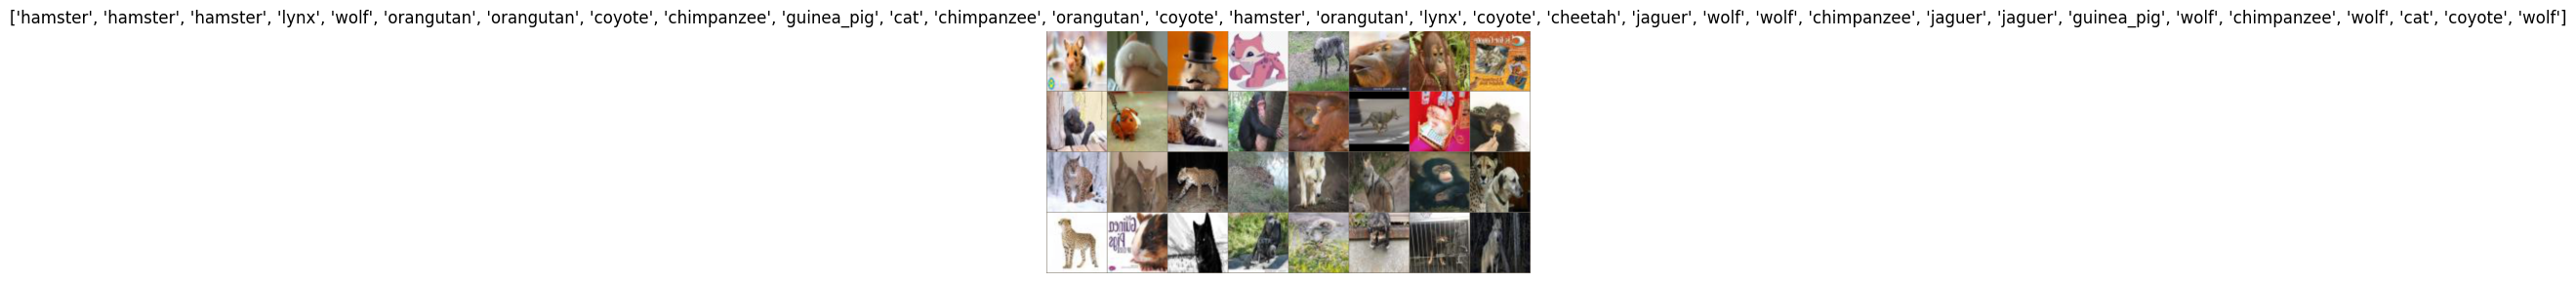

In [ ]:
import torchvision 

# get a batch of training data
images, classes = next(iter(test_loader))

# make a grid from batch
images = torchvision.utils.make_grid(images)

class_names = ds_test.labels.info.class_names
imshow(images, title=[class_names[x] for x in classes])


### Saliency Map

Reference = ChatGPT

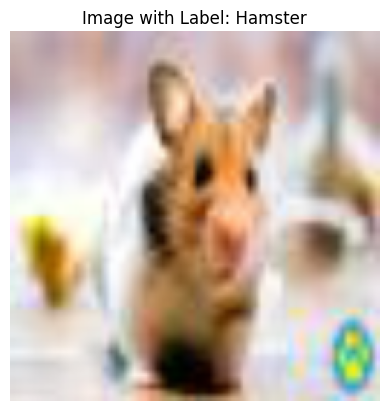

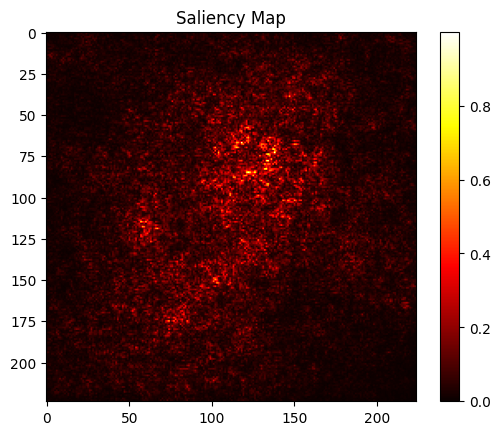

In [ ]:
import torch
import matplotlib.pyplot as plt

def compute_saliency_map(model, image, label, device):
    model.eval()

    image = image.to(device)
    image.requires_grad = True

    # Forward pass
    output = model(image.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)

    # Compute loss
    loss = torch.nn.functional.cross_entropy(output, torch.tensor([label]).to(device))

    # Backward pass to compute gradients
    loss.backward()

    # Get the gradients of the input image
    gradients = torch.abs(image.grad)
    
    # Compute the saliency map by taking the maximum gradient across channels
    saliency_map, _ = torch.max(gradients, dim=0)
    
    # Normalize the saliency map
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-7)

    saliency_map = saliency_map.cpu().numpy()

    return saliency_map


for i, data in enumerate(test_loader):
  image = data['images'][0]
  label = data['labels'][0]
  break

saliency_map = compute_saliency_map(model, image, label, device)

# Denormalize
image = image.numpy().transpose((1, 2, 0)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = image * std + mean
image = np.clip(image, 0, 1)

plt.imshow(image)
plt.title(f'Image with Label: Hamster')
plt.axis('off')
plt.show()

plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()


### Confusion Matrix

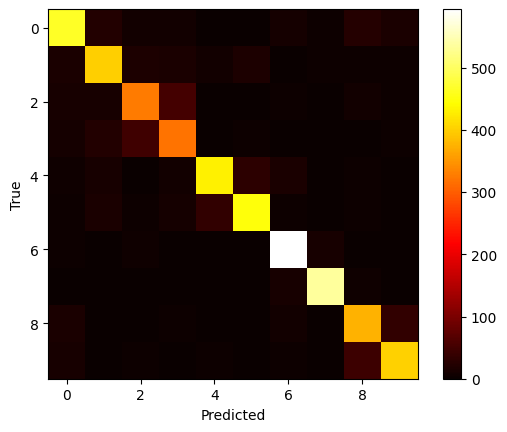

In [ ]:
from torchnet.meter import ConfusionMeter

model.eval()

num_classes = 10
confusion_meter = ConfusionMeter(num_classes)

for i, data in enumerate(test_loader):
    inputs = data['images']
    labels = torch.squeeze(data['labels'])

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs.float())

    _, predicted = torch.max(outputs.data, 1)

    confusion_meter.add(predicted, labels)

confusion_matrix = confusion_meter.conf

plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Model predictions visualizer

Reference = https://leslietj.github.io/2020/07/15/PyTorch-Implementation-of-Class-Activation-Map-CAM/

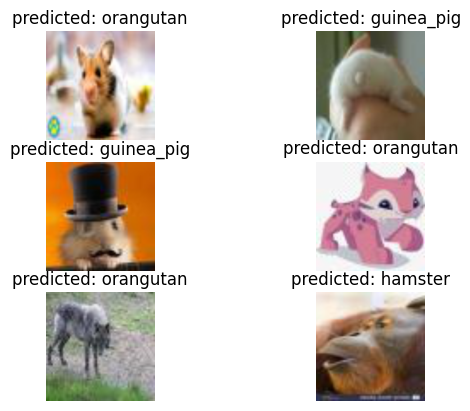

In [ ]:
import torch
import matplotlib.pyplot as plt

# Generic function to display predictions for a few images
def visualize_model(model, test_loader, class_names, num_images=6, device='cpu'):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for step, data in enumerate(test_loader):
            if step < 0:
              continue 

            images = data['images']
            labels = torch.squeeze(data['labels'])

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            _, preds = torch.max(outputs.data, 1)

            for i in range(images.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[i].item()]))
                imshow(images.cpu().data[i])

                if images_so_far == num_images:
                    return


visualize_model(model, test_loader, ds_test.labels.info.class_names)


### Accuracy Plots

The accuracy values have been manually added from the epochs log for each model

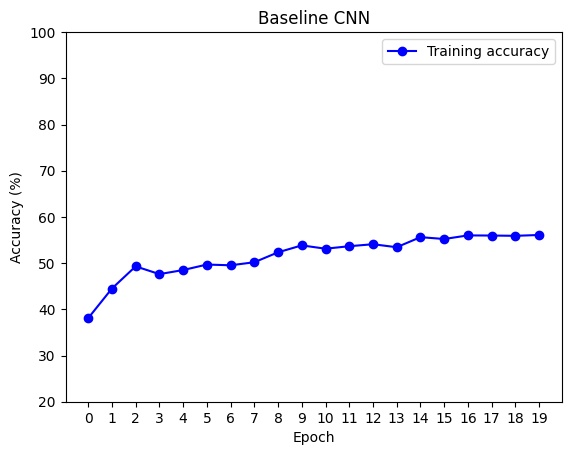

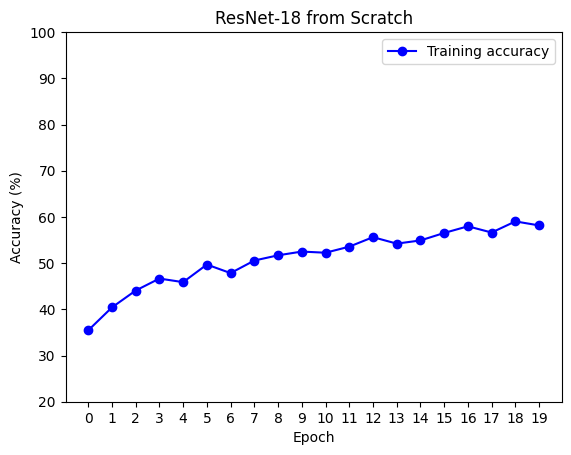

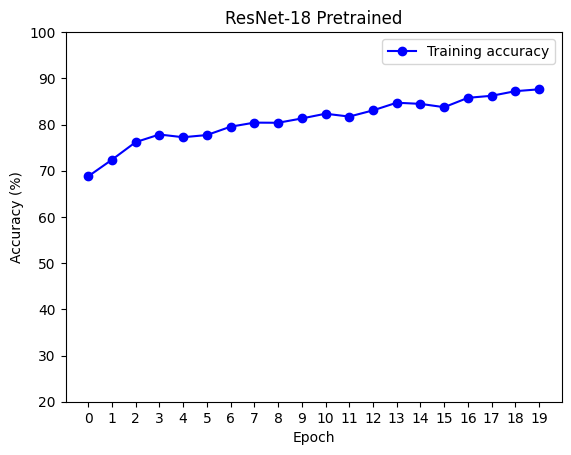

In [ ]:
# Baseline 

import matplotlib.pyplot as plt

epochs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
training_accuracy = [38.09, 44.50, 49.3, 47.62, 48.50, 49.69, 49.53, 50.19, 52.34, 53.84, 53.12, 53.66, 54.09, 53.44, 55.62, 55.22, 56.00, 55.97, 55.91, 56.09 ]

plt.plot(epochs, training_accuracy, 'bo-', label="Training accuracy")
plt.title("Baseline CNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(epochs) 
plt.ylim(20, 100)
plt.legend()
plt.show()

# Resnet from Scratch 

import matplotlib.pyplot as plt

epochs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
training_accuracy = [35.44, 40.41, 44.06, 46.66, 45.88, 49.69, 47.84, 50.56, 51.69, 52.50, 52.25, 53.56, 55.62, 54.22, 54.91, 56.53, 57.97, 56.62, 59.03, 58.16]

plt.plot(epochs, training_accuracy, 'bo-', label="Training accuracy")
plt.title("ResNet-18 from Scratch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(epochs) 
plt.ylim(20, 100)
plt.legend()
plt.show()

# Resnet pre-trained

import matplotlib.pyplot as plt

epochs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
training_accuracy = [68.78, 72.38, 76.19, 77.84, 77.25, 77.72, 79.53, 80.41, 80.38, 81.31, 82.34, 81.72, 83.06, 84.72, 84.47, 83.75, 85.78, 86.22, 87.22, 87.62]
    
plt.plot(epochs, training_accuracy, 'bo-', label="Training accuracy")
plt.title("ResNet-18 Pretrained")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(epochs) 
plt.ylim(20, 100)
plt.legend()
plt.show()



